In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import robustness_metrics as rm

from utils import get_logits_targets, get_acc_per_exit, get_preds_per_exit, raps_eenn
from anytime_predictors import conditional_monotonicity_check, anytime_caching, anytime_product
from plotting_style import *

from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

In [3]:
PRETRAINED_MODELS = {
    "MSDNet": [('cifar10', 'checkpoint_299.pth.tar'), ('cifar100', 'model/checkpoint_299.pth.tar'), ('imagenet', 'checkpoint_089.pth.tar')],
    "IMTA": [('cifar10', 'checkpoint_179.pth.tar'), ('cifar100', 'checkpoint_179.pth.tar'), ('imagenet', 'checkpoint_089.pth.tar')]}

In [14]:
PROBS_DICT, PREDS_DICT, ACC_DICT, TARGETS_DICT = {}, {}, {}, {}
for model_name, models in PRETRAINED_MODELS.items():
    PROBS_DICT[model_name] = {dataset: {} for dataset, _ in models}
    PREDS_DICT[model_name] = {dataset: {} for dataset, _ in models}
    ACC_DICT[model_name] = {dataset: {} for dataset, _ in models}
    TARGETS_DICT[model_name] = {dataset: {} for dataset, _ in models}
    for dataset, model_checkpoint in models:

        logits_type = 'val' if dataset == 'imagenet' else 'test'
        logits, targets = get_logits_targets(dataset=dataset, model=model_name.lower(), checkpoint=model_checkpoint, logits_type=logits_type)
        L, N, C = logits.shape
        
        probs = torch.softmax(logits, dim=2)
        preds = get_preds_per_exit(probs)
        acc = get_acc_per_exit(preds, targets)

        probs_ca= anytime_caching(logits)
        preds_ca = get_preds_per_exit(probs_ca)
        acc_ca = get_acc_per_exit(preds_ca, targets)

        probs_pa = anytime_product(logits, weights=(torch.arange(1, L + 1, 1, dtype=float) / L))
        preds_pa = get_preds_per_exit(probs_pa)
        acc_pa = get_acc_per_exit(preds_pa, targets)

        PROBS_DICT[model_name][dataset] = {'baseline': probs, 'CA': probs_ca, 'PA': probs_pa}
        PREDS_DICT[model_name][dataset] = {'baseline': preds, 'CA': preds_ca, 'PA': preds_pa}
        ACC_DICT[model_name][dataset] = {'baseline': acc, 'CA': acc_ca, 'PA': acc_pa}
        TARGETS_DICT[model_name][dataset] = targets

In [5]:
COLOR_DICT = {"MSDNet": "tab:blue", "IMTA": "tab:green", "DViT": "tab:orange"}
LINE_STYLE_DICT = {"baseline": "-", "PA": "--", "CA": "dotted"}
ENS_TYPES = ["baseline", "PA", "CA"]

# Figure 1

/tmp/ipykernel_958159/2474276312.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0])
/tmp/ipykernel_958159/2474276312.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[1])
/tmp/ipykernel_958159/2474276312.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[2])


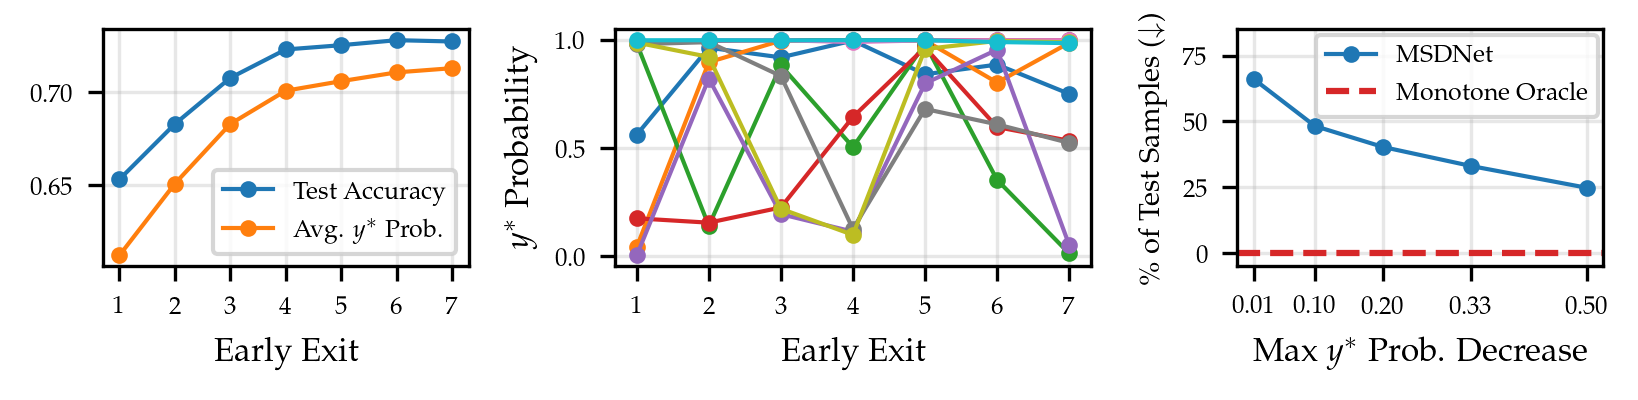

In [6]:
MODEL_NAME = 'MSDNet'
DATASET = 'cifar100'
probs, targets, acc = PROBS_DICT[MODEL_NAME][DATASET]['baseline'], TARGETS_DICT[MODEL_NAME][DATASET], ACC_DICT[MODEL_NAME][DATASET]['baseline']

L = len(ACC_DICT[MODEL_NAME][DATASET]["baseline"])
N = len(targets)
EEs = list(range(1, L + 1))
THRESHOLDS = [0.01, 0.1, 0.2, 0.33, 0.5]


gs = GridSpec(1, 3, width_ratios=[1, 1.3, 1])
fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.25*text_width))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


np.random.seed(40)
IDS = np.random.randint(0, 10000, 10)

probs_gt = torch.stack([probs[:, i, targets[i]] for i in range(N)], dim=1)


ax0.plot(EEs, acc, label='Test Accuracy', marker='o', color='tab:blue')
ax0.plot(EEs, probs_gt.mean(dim=1), label='Avg. $y^*$ Prob.', marker='o', color='tab:orange')

probs_decrase = conditional_monotonicity_check(targets, probs, thresholds=THRESHOLDS) 
ax2.plot(probs_decrase.keys(), probs_decrase.values(), label=MODEL_NAME, marker='o')

for i in IDS:
    probs_i = probs[:, i, targets[i]].cpu()
    ax1.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')

ax0.set_xlabel('Early Exit')
ax0.set_xticks(EEs)
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax0.legend()

ax2.set_xlabel('Max $y^*$ Prob. Decrease')
ax2.set_ylabel('\% of Test Samples ($\downarrow$)', fontsize=7)
ax2.set_xticks(list(probs_decrase.keys()))
ax2.set_ylim([-5., 85.])
ax2.axhline(y=0, color="tab:red", linewidth=1.5, linestyle='--', label='Monotone Oracle')

ax2.legend(loc='upper right', bbox_to_anchor=(1.02, 1.03))

ax1.set_xlabel('Early Exit')
ax1.set_ylabel('$y^*$ Probability')
ax1.set_xticks(EEs)


plt.tight_layout()
plt.show()

# Figure 2

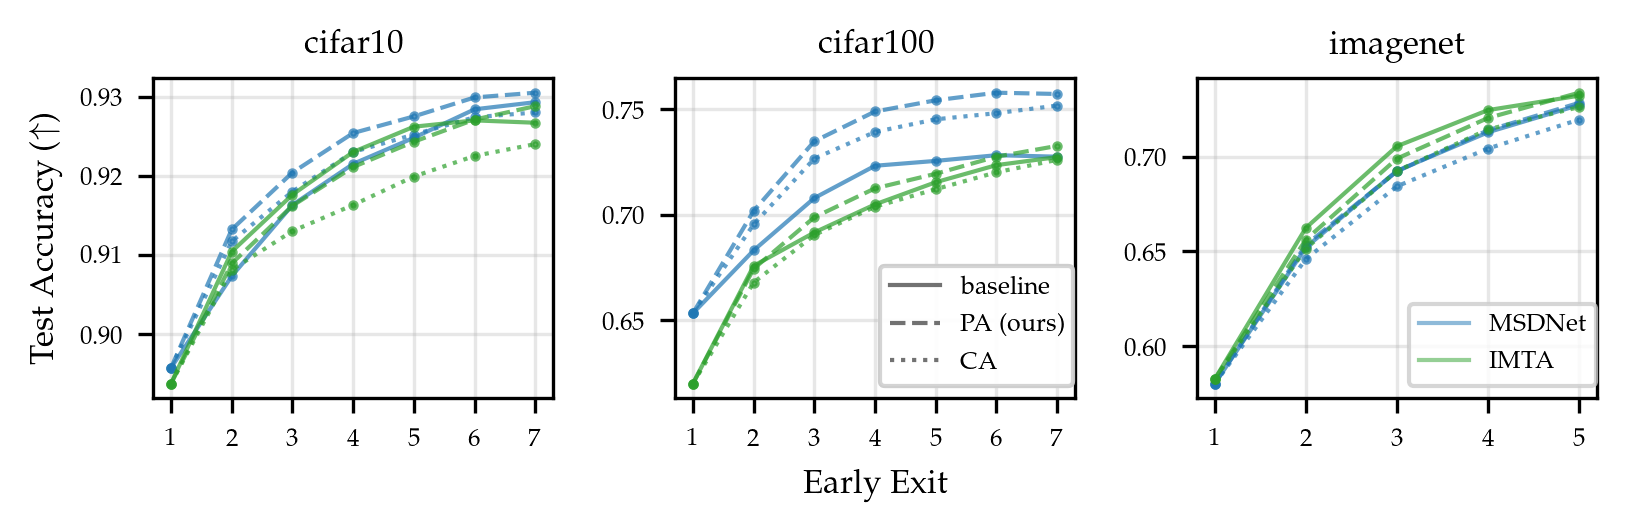

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.33*text_width))

for model_name, model_info in PRETRAINED_MODELS.items():
    for i, dataset_info in enumerate(model_info):

        data, _ = dataset_info
        L = len(ACC_DICT[model_name][data]["baseline"])
        EEs = list(range(1, L + 1))

        for ens_type in ENS_TYPES:
            label = model_name if ens_type == "baseline" else f'{model_name}-{ens_type}'
            ax[i].plot(EEs, ACC_DICT[model_name][data][ens_type], label=label, marker='o', markersize=1.5, 
                       color=COLOR_DICT[model_name], alpha=0.7, linestyle=LINE_STYLE_DICT[ens_type])

            ax[i].set_title(data)
            ax[i].set_xticks(EEs)

# add axis labels
ax[0].set_ylabel('Test Accuracy ($\\uparrow$)')
ax[1].set_xlabel('Early Exit')


# add legend
lines1 = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', alpha=0.5),
]
labels1 = [
    "baseline",
    "PA (ours)",
    "CA"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
]
labels2 = [
    "MSDNet",
    "IMTA",
]

legend1 = ax[1].legend(lines1, labels1, loc='lower left', bbox_to_anchor=(0.48, 0.))
legend2 = ax[2].legend(lines2, labels2, loc='lower left', bbox_to_anchor=(0.5, 0.))
ax[1].add_artist(legend1)


plt.show()

# Figure 3

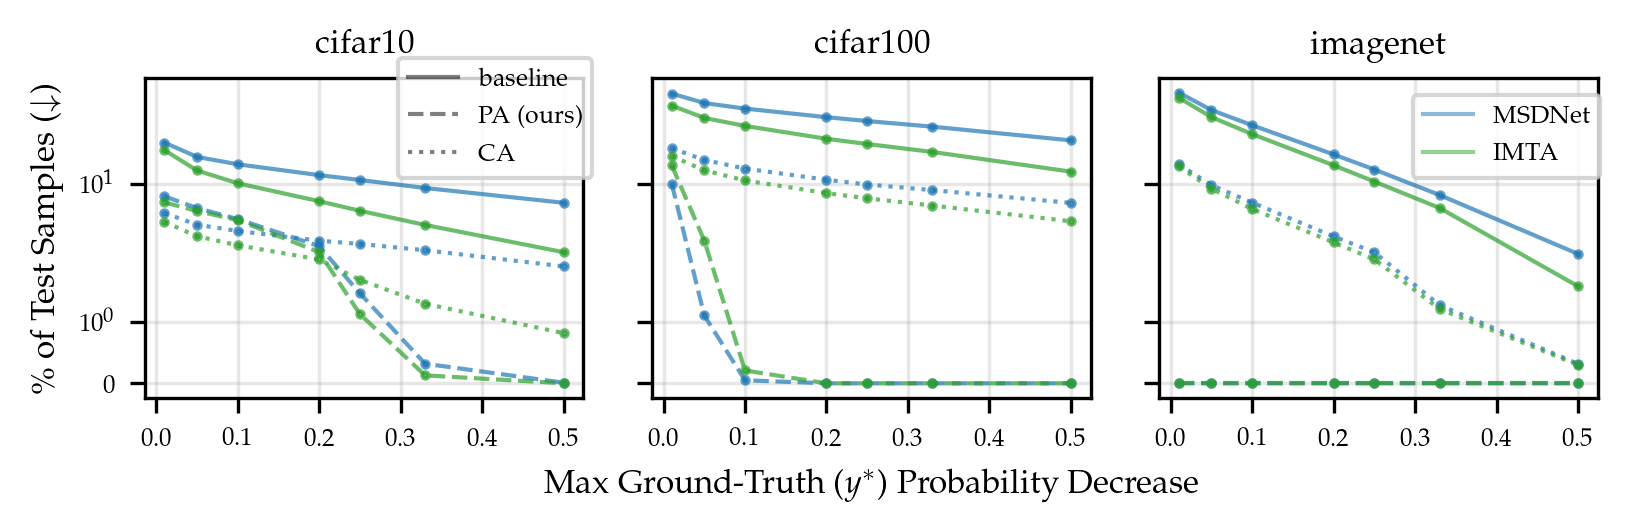

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 0.33), sharex=True, sharey=True)

THRESHOLDS = [0.01, 0.05, 0.1, 0.2, 0.25, 0.33, 0.5]

for model_name, model_info in PRETRAINED_MODELS.items():
    for i, dataset_info in enumerate(model_info):

        data, _ = dataset_info

        for ens_type in ENS_TYPES:
            label = model_name if ens_type == "baseline" else f'{model_name}-{ens_type}'
            probs_decrase = conditional_monotonicity_check(TARGETS_DICT[model_name][data], 
                                                           PROBS_DICT[model_name][data][ens_type], thresholds=THRESHOLDS)

            ax[i].plot(probs_decrase.keys(), probs_decrase.values(), label=label, marker='o', markersize=1.5, 
                       color=COLOR_DICT[model_name], alpha=0.7, linestyle=LINE_STYLE_DICT[ens_type])
            
        ax[i].set_title(data)
        ax[i].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
        ax[i].set_yscale('symlog')

# add axis labels
ax[0].set_ylabel('\% of Test Samples ($\downarrow$)')
ax[1].set_xlabel('Max Ground-Truth ($y^*$) Probability Decrease')

# add legend
lines1 = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='dotted', alpha=0.5),
]
labels1 = [
    "baseline",
    "PA (ours)",
    "CA"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
]
labels2 = [
    "MSDNet",
    "IMTA",
]

legend1 = ax[0].legend(lines1, labels1, loc='lower left', bbox_to_anchor=(0.55, 0.65))
legend2 = ax[2].legend(lines2, labels2, loc='lower left', bbox_to_anchor=(0.55, 0.65))

plt.tight_layout()
plt.show()

# Figure 4

/tmp/ipykernel_958159/67548716.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0])
/tmp/ipykernel_958159/67548716.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[1])
/tmp/ipykernel_958159/67548716.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[2])


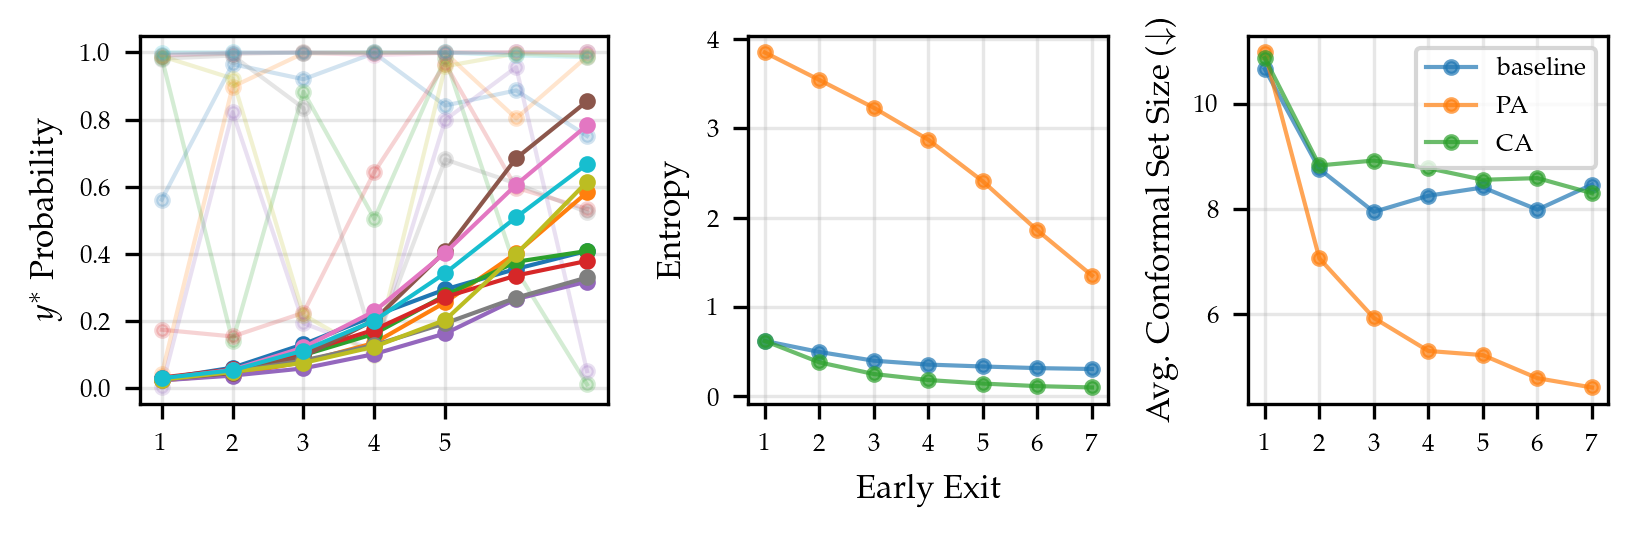

In [9]:
gs = GridSpec(1, 3, width_ratios=[1.3, 1, 1])
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4 / 12), sharex=True)


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

TARGETS = TARGETS_DICT['MSDNet']['cifar100']


np.random.seed(40)
IDS = np.random.randint(0, 10000, 10)
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
for model_type in ENS_TYPES:
    if model_type == 'CA':
        continue
    probs = PROBS_DICT['MSDNet']['cifar100'][model_type]
    alpha = 0.2 if model_type == 'baseline' else 1.
    for j, i in enumerate(IDS):
        probs_i = probs[:, i, TARGETS[i]].cpu()
        ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', alpha=alpha, color=COLORS[j])

ax0.set_ylabel('$y^*$ Probability')
ax0.set_xticks(list(range(1, L + 1)))


for model_type in ENS_TYPES:
    probs = PROBS_DICT['MSDNet']['cifar100'][model_type]
    EEs = list(range(1, probs.shape[0] + 1))
    ent = entropy(probs.numpy(), axis=2)
    ax1.plot(EEs, ent.mean(axis=1), marker='o', label=model_type, alpha=0.7)

ax1.set_ylabel('Entropy')
ax1.set_xlabel('Early Exit')
ax1.set_xticks(EEs)


for model_type in ENS_TYPES:
    probs = PROBS_DICT['MSDNet']['cifar100'][model_type]
    L, _, C = probs.shape
    EEs = list(range(1, L + 1))

    sizes_conf_sets, _ = raps_eenn(probs.cpu().numpy(), TARGETS)
    ax2.plot(EEs, sizes_conf_sets, marker='o', label=model_type, alpha=0.7)

ax2.set_ylabel('Avg. Conformal Set Size ($\downarrow$)')
ax2.set_xticks(list(range(1, L + 1)))
ax2.legend()


plt.tight_layout()
plt.show()

# Figure 5

In [12]:
logits, targets = get_logits_targets(dataset='cifar100', model="msdnet", checkpoint='model_finetune/checkpoint_299.pth.tar')
probs_pa_ft = anytime_product(logits)
preds_pa_ft = get_preds_per_exit(probs_pa_ft)
acc_pa_ft = get_acc_per_exit(preds_pa_ft, targets)


ENS_TYPES += ['PA Finetune']
PROBS_DICT['MSDNet']['cifar100']['PA Finetune'] = probs_pa_ft
PREDS_DICT['MSDNet']['cifar100']['PA Finetune'] = preds_pa_ft

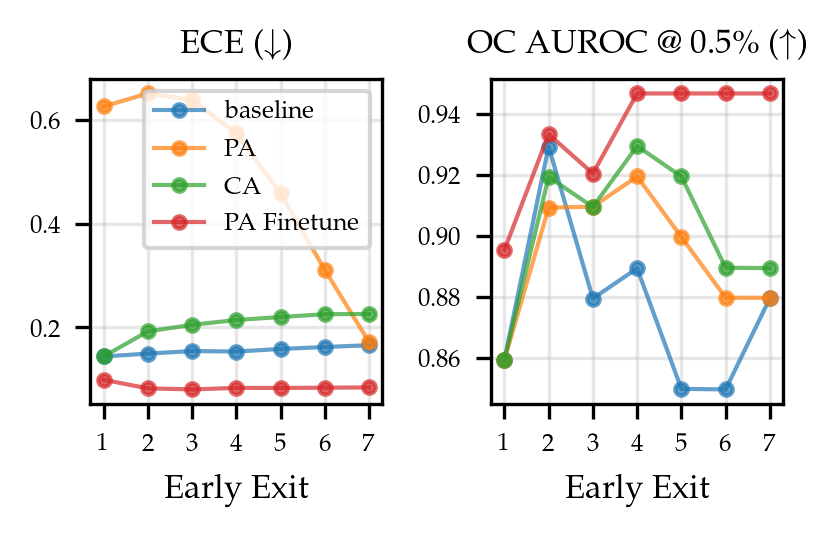

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(text_width * 0.5, text_width * 4 / 12), sharex=True)

FRACTION = 0.005
for model_type in ENS_TYPES:
    probs = PROBS_DICT['MSDNet']['cifar100'][model_type]
    preds = PREDS_DICT['MSDNet']['cifar100'][model_type]
    EEs = list(range(1, probs.shape[0] + 1))

    eces_rm = []
    for l in range(L):
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    ax[0].plot(EEs, eces_rm, '-', marker='o', label=model_type, alpha=0.7)

    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[1].plot(EEs, oracle_aucs, '-', marker='o',  label=model_type, alpha=.7)


ax[0].set_title('ECE ($\downarrow$)')
ax[0].set_xlabel('Early Exit')
ax[0].set_xticks(EEs)
ax[1].set_title(f"OC AUROC @ {FRACTION * 100}\\% ($\\uparrow$)")
ax[1].set_xlabel('Early Exit')
ax[1].set_xticks(EEs)

ax[0].legend()


plt.tight_layout()
plt.show()